In [124]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

## parameters

In [187]:
class p:
    # data parameters
    N = 200 # N is batch size
    D_in = 1 # D_in is input dimension
    D_out = 2 # D_out is output dimension
    means = [[0], [20], [40]] # means of gaussian data
    sds = [[1], [1], [1]] # sds of data
    labs = [0, 1, 0] # labels of these gaussians
    
    # model parameters
    H = 1 # H is hidden dimension
    
    # fitting paramters
    lr = 0.00001
    num_iters = int(1e4)
    step_size_optimizer = 1000
    gamma_optimizer = 0.9

# generate data

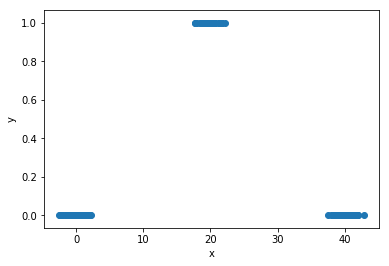

In [188]:
# generate mixture model
# means and sds should be lists of lists (sds just scale variances)
def generate_gaussian_data(N, means=[[0], [1]], sds=[1, 1], labs=[0, 1]):
    num_means = len(means)
    P = len(means[0])
    X = np.zeros((N, P), dtype=np.float32)
    y_plot = np.zeros((N, 1), dtype=np.float32)
    y_one_hot = np.zeros((N, 2), dtype=np.float32)
    for i in range(N):
        z = np.random.randint(num_means) # select gaussian
        X[i] = np.random.multivariate_normal(means[z], np.eye(P) * sds[z])
        y_plot[i] = labs[z]
        y_one_hot[i, labs[z]] = 1
    return X, y_one_hot, y_plot


# data to torch
class dset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, idx):
        return X[idx], y[idx]
    def __len__(self):
        return y.size

X, y, y_plot = generate_gaussian_data(p.N, means=p.means, sds=p.sds, labs=p.labs)
dset = dset(X, y)
plt.scatter(X, y_plot)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## run + fit

In [189]:
# data to torch
X_torch = torch.from_numpy(X)
y_torch = torch.from_numpy(y)

# make model
model = torch.nn.Sequential(
    torch.nn.Linear(p.D_in, p.H),
    torch.nn.ReLU(),
    torch.nn.Linear(p.H, p.D_out),
)

# set up optimization
optimizer = torch.optim.SGD(model.parameters(), lr=p.lr) # only optimize ridge (otherwise use model.parameters())
scheduler = StepLR(optimizer, step_size=p.step_size_optimizer, gamma=p.gamma_optimizer)
loss_fn = torch.nn.MSELoss(size_average=False)


# to record
weights = {}
losses = np.zeros(p.num_iters)


# fit
for it in tqdm(range(p.num_iters)):
    y_pred = model(Variable(X_torch, requires_grad=True)) # predict
    loss = loss_fn(y_pred, Variable(y_torch)) # calculate loss
    optimizer.zero_grad() # zero the gradients
    loss.backward() # backward pass
    optimizer.step() # update weights
    scheduler.step() # step for incrementing optimizer

    # output
    losses[it] = loss.data[0]        
    if it % 100 == 0:
        weights[it] = model.named_parameters()



100%|██████████| 10000/10000 [00:02<00:00, 4695.76it/s]


# analyze results

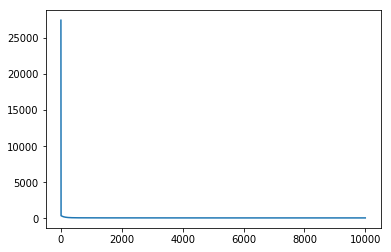

In [190]:
plt.plot(losses)
plt.show()

In [191]:
# print output weights
for name, param in weights[max(weights.keys())]:
    print(name, param.data)

0.weight 
1.00000e-02 *
 -5.3803
[torch.FloatTensor of size 1x1]

0.bias 
 0.9543
[torch.FloatTensor of size 1]

2.weight 
 0.4615
-0.4638
[torch.FloatTensor of size 2x1]

2.bias 
 0.5555
 0.4454
[torch.FloatTensor of size 2]

